## 6.1.1 LeNet-5

In [47]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms #이미지 전처리 기능 제공 라이브러리
from torch.autograd import Variable
from torch import optim #경사 하강법을 이용한 가중치 구하기 위한 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os #파일 경로에 대한 함수 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가시적으로 표현(모델의 학습 경과)
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU 할당

In [48]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [49]:
#데이터 가져오기
from google.colab import files
file_uploaded=files.upload()

Saving dogs-vs-cats.zip to dogs-vs-cats (1).zip


In [50]:
#dogs-vs-cats 폴더에 압축 풀기
!unzip dogs-vs-cats.zip -d data/dogs-vs-cats/

Archive:  dogs-vs-cats.zip
replace data/dogs-vs-cats/Cat/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: data/dogs-vs-cats/Cat/cat.0.jpg  
replace data/dogs-vs-cats/Cat/cat.1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: data/dogs-vs-cats/Cat/cat.1.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.10.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.100.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.101.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.102.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.103.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.104.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.105.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.106.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.107.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.108.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.109.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.11.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.110.jpg  
  inflating: data/dogs-vs-cats/Cat/cat.111.jpg  
  inflating: data/dogs-vs-cat

In [51]:
#이미지 데이터셋 훈련,검증,테스트로 분리
cat_directory = 'data/dogs-vs-cats/Cat/'
dog_directory = 'data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
#개,고양이 이미지를 합쳐서 저장
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400] #훈련용
val_images_filepaths = correct_images_filepaths[400:-10] #검증용
test_images_filepaths = correct_images_filepaths[-10:] #테스트용
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [52]:
#테스트 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        #정답일 시 초록색, 오답이면 빨간색
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image) #개별 이미지 출력
        ax.ravel()[i].set_title(predicted_label, color=color) #predicted_label을 타이틀로
        ax.ravel()[i].set_axis_off() #이미지 축 제거
    plt.tight_layout() #이미지 여백 조정
    plt.show()

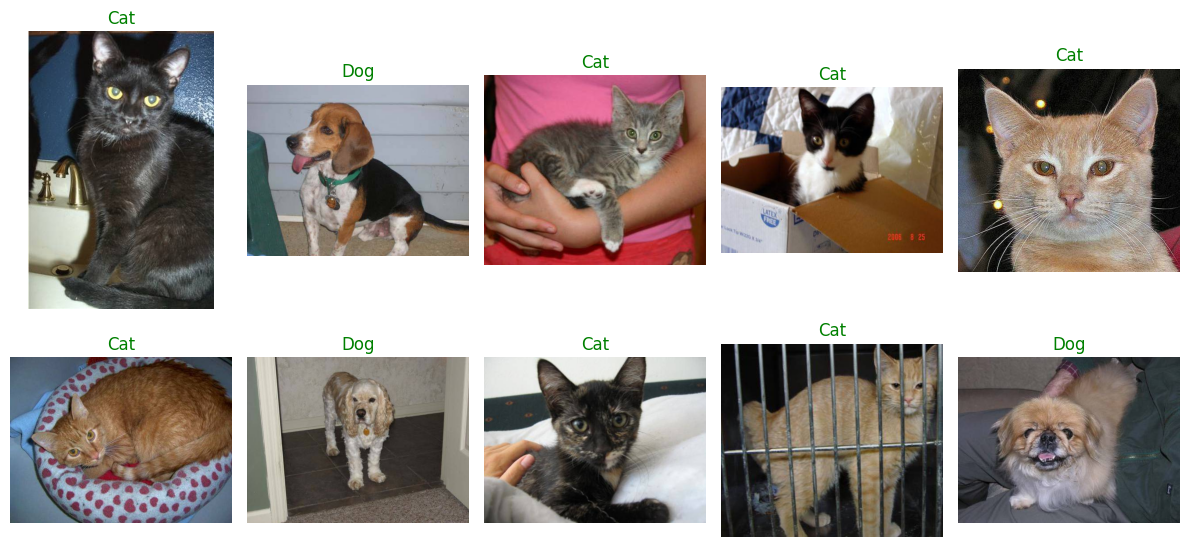

In [53]:
#테스트 데이터셋 출력
display_image_grid(test_images_filepaths)

In [54]:
#이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'): #데이터셋의 전처리
        self.file_list = file_list
        self.transform = transform #클래스 호출 시 transform에 대한 매개변수 받아옴
        self.phase = phase #train 적용

    def __len__(self): #images_filepaths 데이터셋의 전체 길이 반환
        return len(self.file_list)

    def __getitem__(self, idx): #데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태
        img_path = self.file_list[idx]
        img = Image.open(img_path) #img_path 위치에서 이미지 데이터들을 가져옴
        img_transformed = self.transform(img, self.phase) #이미지에 train 전처리 적용

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [55]:
#변수값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [56]:
#이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [57]:
#데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader} #훈련.검증 데이터셋을 합쳐 표현

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1])


In [58]:
#모델의 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #입력 형태: 3*224*224, 출력 형태: 16*220*220
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #max pooling 적용(출력 형태: 16*110*100)
        #출력 형태: 32*106*106
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #max pooling 적용(출력 형태: 32*53*53)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) #fc에 데이터 전달하기 위해 데이터 형태를 1차원으로
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [59]:
#모델 객체 생성
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [60]:
#torchsummary 라이브러리 설치
!pip install torchsummary

In [61]:
#torchsummary를 이용한 모델의 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [62]:
#학습 가능 파라미터 수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [63]:
#옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [64]:
#모델 파라미터와 손실 함수를 device에 할당
model = model.to(device)
criterion = criterion.to(device)

In [65]:
#모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch): #num_epoch만큼 반복
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #모델 학습
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]): #dataloader_dict==훈련 데이터셋(train_loader)
                inputs = inputs.to(device) #훈련데이터셋 device에 할당
                labels = labels.to(device)
                optimizer.zero_grad() #역전파 실행 전 기울기 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) #손실 함수를 이용한 오차 계산

                    if phase == 'train':
                        loss.backward() #모델의 학습 가능한 모든 파라미터에 대해 기울기 계산
                        optimizer.step() #optimizer의 step 함수를 호출하면 파라미터 갱신

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data) #정답일 시 합계를 저장

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset) #최종 오차 계산
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset) #최종 정확도 계산

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc: #검증 데이터셋에 대한 최적의 정확도 저장
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [66]:
#모델 학습
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-65-bbad4178232a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]): #dataloader_dict==훈련 데이터셋(train_loader)


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6946 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7027 Acc: 0.4348
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6847 Acc: 0.5825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7032 Acc: 0.4674
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6794 Acc: 0.5950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7021 Acc: 0.4565
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6763 Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7045 Acc: 0.4783
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6671 Acc: 0.6175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6974 Acc: 0.5109
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6633 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6894 Acc: 0.5326
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6640 Acc: 0.6050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6970 Acc: 0.5326
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6538 Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6795 Acc: 0.5761
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6538 Acc: 0.6525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6860 Acc: 0.5435
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6553 Acc: 0.6150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6724 Acc: 0.5870
Training complete in 5m 22s
Best val Acc: 0.586957


In [67]:
#모델 테스트를 위한 함수 정의
import pandas as pd

id_list = []
pred_list = []
_id=0
with torch.no_grad(): #역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음(훈련과의 차이점)
    for test_path in tqdm(test_images_filepaths): #테스트 데이터셋 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') #테스트 데이터셋 전처리 이용
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
}) #테스트 데이터셋의 예측 결과인 id와 label을 저장

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('LesNet.csv', index=False) #df->csv

<ipython-input-67-0df0b3ab7470>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): #테스트 데이터셋 이용


  0%|          | 0/10 [00:00<?, ?it/s]

In [68]:
#테스트 데이터셋의 예측 결과 호출
res.head(10)

,id,label
0,109,0.505550
1,145,0.458985
2,15,0.609739
3,162,0.513683
4,167,0.542493
5,200,0.419106
6,210,0.621706
7,211,0.586320
8,213,0.435148
9,224,0.638046


In [69]:
#테스트 데이터셋 이미지 출력하기 위한 함수 정의
class_ = classes = {0:'cat', 1:'dog'} #개, 고양이 클래스 정의
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values) #df의 id라는 칼럼에서 임의로 데이터 가져오기
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1 #개
        else:
            label = 0 #고양이
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

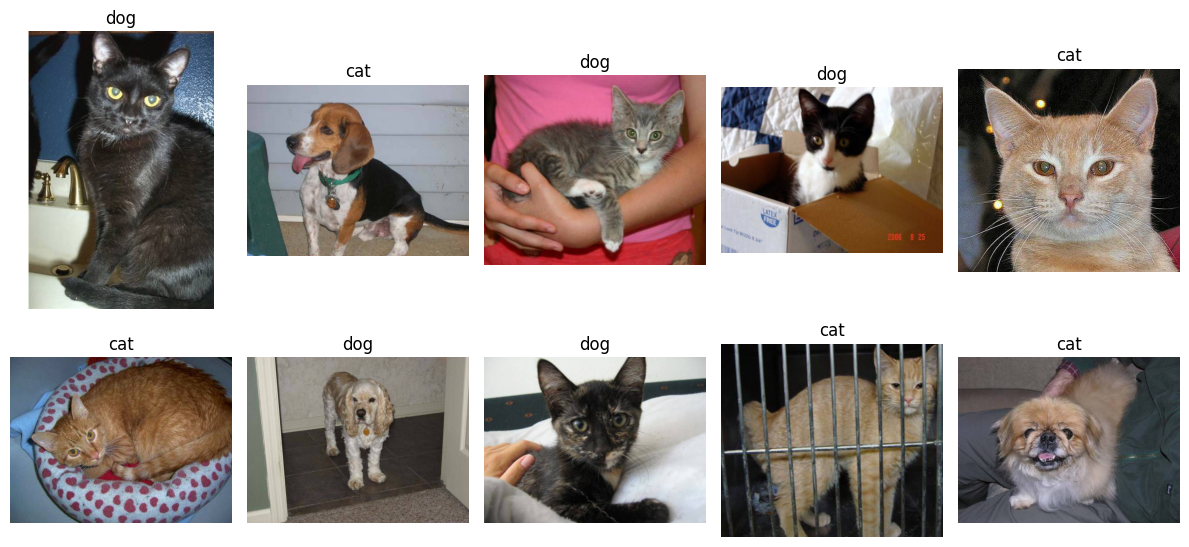

In [70]:
#테스트 데이터셋 예측 결과 이미지 출력
display_image_grid(test_images_filepaths)

## 6.1.2 AlexNet

In [ ]:
#필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#데이터 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
#데이터 가져와서 훈련,검증,테스트 용도로 분리
cat_directory = 'data/dogs-vs-cats/Cat/'
dog_directory = 'data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [ ]:
#커스텀 데이터셋 정의
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list #이미지 데이터 위치한 파일 경로
        self.transform = transform #이미지 데이터 전처리
        self.phase = phase #self.phase는 ImageTransform()에서 정의한 train, val 의미

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx] #이미지 인덱스 가져오기
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0] #레이블 값 가져오기
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label #전처리 적용된 이미지와 레이블 반환

In [ ]:
#변수에 대한 값 정의
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
#훈련,검증,테스트 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [ ]:
#데이터셋을 메모리로 불러옴
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 1])


In [ ]:
#AlexNet 모델 네트워크 정의
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
#model 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#옵티마이저 및 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
#모델 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
#모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [ ]:
#모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-37-f3dd31421ea5>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6939 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6942 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6936 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6940 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4891
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6936 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6938 Acc: 0.4891
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6936 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6935 Acc: 0.4891
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6934 Acc: 0.4891
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.4891
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.4891
Training complete in 9m 15s


In [ ]:
#모델을 이용한 예측
import pandas as pd

id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths): #테스트 데이터 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1] #이미지 데이터의 번호 가져오기
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') #테스트 데이터에 검증용 전처리 적용
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('alexnet.csv', index=False) #이미지의 id와 레이블을 csv 파일에 저장

<ipython-input-39-ef182f5c0aa9>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#데이터프레임 결과 확인
res.head(10)

,id,label
0,145,0.497561
1,211,0.498254
2,162,0.497571
3,200,0.498583
4,210,0.498195
5,224,0.497251
6,213,0.497575
7,109,0.498212
8,15,0.497594
9,167,0.497298


In [ ]:
#예측 결과를 시각적으로 표현하기 위한 함수 정의
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

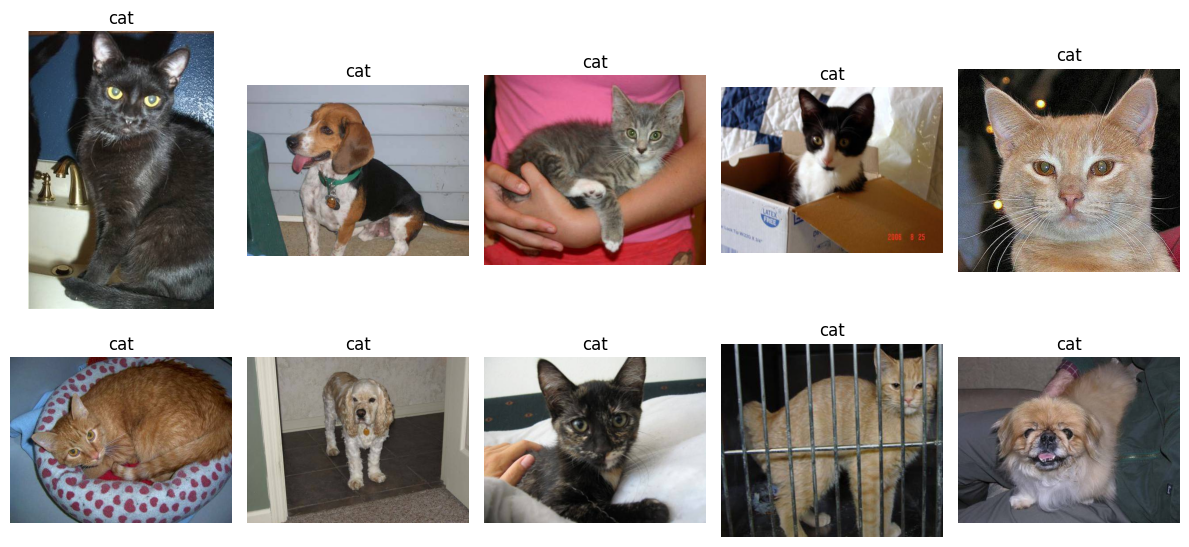

In [ ]:
#예측 결과에 대해 이미지와 함께 출력
display_image_grid(test_images_filepaths)